## Comparison of CAI, tAI and modelled translation efficiencies

In [1]:
import os
import os.path
import cPickle as pkl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import pandas as pd
import numpy as np

from Bio import SeqIO
from statsmodels.nonparametric.smoothers_lowess import lowess

### tRNA adaptation index (tAI)

From https://github.com/smsaladi/tAI:

In [2]:
import tAI

Codon Usage from http://www.kazusa.or.jp/codon/cgi-bin/showcodon.cgi?species=4932:

```
Saccharomyces cerevisiae [gbpln]: 14411 CDS's (6534504 codons)
fields: [triplet] [frequency: per thousand] ([number])
UUU 26.1(170666)  UCU 23.5(153557)  UAU 18.8(122728)  UGU  8.1( 52903)
UUC 18.4(120510)  UCC 14.2( 92923)  UAC 14.8( 96596)  UGC  4.8( 31095)
UUA 26.2(170884)  UCA 18.7(122028)  UAA  1.1(  6913)  UGA  0.7(  4447)
UUG 27.2(177573)  UCG  8.6( 55951)  UAG  0.5(  3312)  UGG 10.4( 67789)

CUU 12.3( 80076)  CCU 13.5( 88263)  CAU 13.6( 89007)  CGU  6.4( 41791)
CUC  5.4( 35545)  CCC  6.8( 44309)  CAC  7.8( 50785)  CGC  2.6( 16993)
CUA 13.4( 87619)  CCA 18.3(119641)  CAA 27.3(178251)  CGA  3.0( 19562)
CUG 10.5( 68494)  CCG  5.3( 34597)  CAG 12.1( 79121)  CGG  1.7( 11351)

AUU 30.1(196893)  ACU 20.3(132522)  AAU 35.7(233124)  AGU 14.2( 92466)
AUC 17.2(112176)  ACC 12.7( 83207)  AAC 24.8(162199)  AGC  9.8( 63726)
AUA 17.8(116254)  ACA 17.8(116084)  AAA 41.9(273618)  AGA 21.3(139081)
AUG 20.9(136805)  ACG  8.0( 52045)  AAG 30.8(201361)  AGG  9.2( 60289)

GUU 22.1(144243)  GCU 21.2(138358)  GAU 37.6(245641)  GGU 23.9(156109)
GUC 11.8( 76947)  GCC 12.6( 82357)  GAC 20.2(132048)  GGC  9.8( 63903)
GUA 11.8( 76927)  GCA 16.2(105910)  GAA 45.6(297944)  GGA 10.9( 71216)
GUG 10.8( 70337)  GCG  6.2( 40358)  GAG 19.2(125717)  GGG  6.0( 39359)
```

In [3]:
tRNA_types = {
    1: {'anticodon': 'ugc', 'abundancy': 55351},  # reverse complement the anticodon to look it up
    2: {'anticodon': 'agc', 'abundancy': 121771},
    3: {'anticodon': 'ucu', 'abundancy': 121771},
    4: {'anticodon': 'ccu', 'abundancy': 11070},
    5: {'anticodon': 'ccg', 'abundancy': 11070},
    6: {'anticodon': 'acg', 'abundancy': 66421},
    7: {'anticodon': 'guu', 'abundancy': 110701},
    8: {'anticodon': 'guc', 'abundancy': 177122},
    9: {'anticodon': 'gca', 'abundancy': 44280},
    10: {'anticodon': 'uug', 'abundancy': 88561},
    11: {'anticodon': 'cug', 'abundancy': 11070},
    12: {'anticodon': 'uuc', 'abundancy': 154982},
    13: {'anticodon': 'ucc', 'abundancy': 33210},
    14: {'anticodon': 'ccc', 'abundancy': 22140},
    15: {'anticodon': 'gcc', 'abundancy': 177122},
    16: {'anticodon': 'gug', 'abundancy': 77491},
    17: {'anticodon': 'uau', 'abundancy': 22140},
    18: {'anticodon': 'aau', 'abundancy': 143911},
    19: {'anticodon': 'uag', 'abundancy': 33210},
    20: {'anticodon': 'gag', 'abundancy': 11070},
    21: {'anticodon': 'uaa', 'abundancy': 77491},
    22: {'anticodon': 'caa', 'abundancy': 110701},
    23: {'anticodon': 'uuu', 'abundancy': 77491},
    24: {'anticodon': 'cuu', 'abundancy': 154982},
    25: {'anticodon': 'cau', 'abundancy': 55351},  # 26 does not seem to exist
    27: {'anticodon': 'gaa', 'abundancy': 110701},
    28: {'anticodon': 'agg', 'abundancy': 22140},
    29: {'anticodon': 'ugg', 'abundancy': 110701},
    30: {'anticodon': 'gcu', 'abundancy': 33210},
    31: {'anticodon': 'uga', 'abundancy': 33210},
    32: {'anticodon': 'aga', 'abundancy': 121771},
    33: {'anticodon': 'cga', 'abundancy': 11070},
    34: {'anticodon': 'ugu', 'abundancy': 44280},
    35: {'anticodon': 'agu', 'abundancy': 121771},
    36: {'anticodon': 'cgu', 'abundancy': 11070},
    37: {'anticodon': 'cca', 'abundancy': 66421},
    38: {'anticodon': 'gua', 'abundancy': 88561},
    39: {'anticodon': 'uac', 'abundancy': 22140},
    40: {'anticodon': 'aac', 'abundancy': 154982},
    41: {'anticodon': 'cac', 'abundancy': 22140},
    42: {'anticodon': '*', 'abundancy': 18000},  # termination factor
    43: {'anticodon': 'cuc', 'abundancy': 22140}
}

In [4]:
codon_anticodon = {
    'uuu': 'gaa', 'ucu': 'aga', 'uau': 'gua', 'ugu': 'gca',
    'uuc': 'gaa', 'ucc': 'aga', 'uac': 'gua', 'ugc': 'gca',
    'uua': 'uaa', 'uca': 'uga', 'uaa': '*', 'uga': '*',  # '*'==stop
    'uug': 'caa', 'ucg': 'cga', 'uag': '*', 'ugg': 'cca',
    'cuu': 'gag', 'ccu': 'agg', 'cau': 'gug', 'cgu': 'acg',
    'cuc': 'gag', 'ccc': 'agg', 'cac': 'gug', 'cgc': 'acg',
    'cua': 'uag', 'cca': 'ugg', 'caa': 'uug', 'cga': 'acg',
    'cug': 'uag', 'ccg': 'ugg', 'cag': 'cug', 'cgg': 'ccg',
    'auu': 'aau', 'acu': 'agu', 'aau': 'guu', 'agu': 'gcu',
    'auc': 'aau', 'acc': 'agu', 'aac': 'guu', 'agc': 'gcu',
    'aua': 'uau', 'aca': 'ugu', 'aaa': 'uuu', 'aga': 'ucu',
    'aug': 'cau', 'acg': 'cgu', 'aag': 'cuu', 'agg': 'ccu',
    'guu': 'aac', 'gcu': 'agc', 'gau': 'guc', 'ggu': 'gcc',
    'guc': 'aac', 'gcc': 'agc', 'gac': 'guc', 'ggc': 'gcc',
    'gua': 'uac', 'gca': 'ugc', 'gaa': 'uuc', 'gga': 'ucc',
    'gug': 'cac', 'gcg': 'ugc', 'gag': 'cuc', 'ggg': 'ccc'
}

From https://github.com/gittenberg/TRSL/blob/master/workbooks/analyses/03%20TRSL_check_observables.ipynb:

In [5]:
anticodon_tRNA_abundancy = {tRNA_types[id]['anticodon']: tRNA_types[id]['abundancy'] for id in tRNA_types}

In [6]:
codon_tRNA_abundancy = {codon: anticodon_tRNA_abundancy[codon_anticodon[codon]] for codon in codon_anticodon}
#codon_tRNA_abundancy

Delete stop codons:

In [7]:
del codon_tRNA_abundancy['uaa']
del codon_tRNA_abundancy['uga']
del codon_tRNA_abundancy['uag']

In [8]:
orfs = pkl.load(open("../../parameters/orf_coding.p", "rb"))

Test case (SWI5, YDR146C):

In [9]:
nucseq = orfs['YDR146C']
nucseq[:60]

'auggauacaucaaacucuugguuugaugccucaaaaguacaaagccuaaauuuugaccua'

In [10]:
codon_tRNA_abundancy_series = pd.Series({key.upper().replace('U', 'T'): codon_tRNA_abundancy[key] 
                                         for key in codon_tRNA_abundancy})

### Calculate using tAI from Python and Chu tRNA abundancies

In [11]:
my_tAI = tAI.tAI(trna_count=codon_tRNA_abundancy_series)

In [12]:
tAI_dict_python_from_dict = {}

for orf in orfs:
    tAI_dict_python_from_dict[orf] = my_tAI.calc(orfs[orf])

### Calculate using tAI from R

Import tAIs from R:

In [13]:
with open('/home/martin/git/TRSL/workbooks/analyses/tAI_misc/yeast.json','r') as inf:
    tAI_dict_R = eval(inf.read())

In [14]:
tAI_dict_R['YDR146C']

0.33496

### Calculate using tAI from Python and gtRNAdb (http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/)

In [15]:
rootdir = os.getcwd()
datadir = os.path.join(os.getcwd(), "tAI-master/test/data")

In [16]:
tAI_dict_python_from_gtrnadb = {}

my_tai = tAI.tAI.from_gtRNAdb(os.path.join(datadir, r"sacCer3-tRNAs.bed"))

In [17]:
for r in orfs:
    tAI_dict_python_from_gtrnadb[r] = my_tai.calc(orfs[r])

In [18]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2, xlog=True, ylog=True):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-')
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys, color='b', alpha=alpha)
    scat.set_alpha(alpha)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs, missing='raise', return_sorted=True)[:,1]
    
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

5917


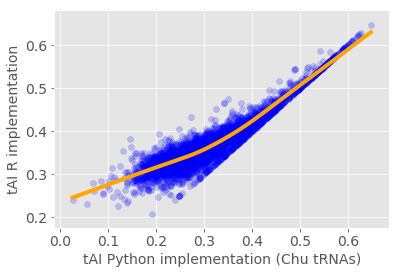

In [19]:
scatter_dicts(tAI_dict_python_from_dict, tAI_dict_R, "tAI Python implementation (Chu tRNAs)", 
              "tAI R implementation", 14, 0.2, False, False)

5917


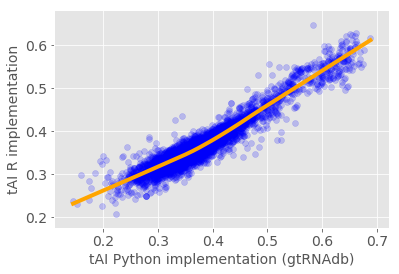

In [20]:
scatter_dicts(tAI_dict_python_from_gtrnadb, tAI_dict_R, "tAI Python implementation (gtRNAdb)", 
              "tAI R implementation", 14, 0.2, False, False)

In [21]:
pd.Series(tAI_dict_python_from_gtrnadb).describe()

count    6713.000000
mean        0.358015
std         0.076301
min         0.141384
25%         0.314824
50%         0.344046
75%         0.384546
max         0.688190
dtype: float64

In [22]:
pd.Series(tAI_dict_R).describe()

count    5917.000000
mean        0.360478
std         0.055738
min         0.207780
25%         0.328900
50%         0.346170
75%         0.374460
max         0.647590
dtype: float64

Similar enough so we can take one of the two.

6713


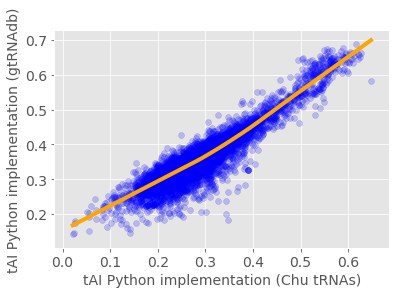

In [23]:
scatter_dicts(tAI_dict_python_from_dict, tAI_dict_python_from_gtrnadb, "tAI Python implementation (Chu tRNAs)", 
              "tAI Python implementation (gtRNAdb)", 14, 0.2, False, False)

We can get a preliminary idea of which one is correct by testing two hypotheses:

1. Among genes with similar transcript levels, higher tAI often corresponds to higher protein abundance (http://www.nature.com/ng/journal/v39/n3/full/ng1967.html)
2. Codon bias was positively correlated to mRNA abundance, ribosome occupancy, and translation efficiency (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3941107/)

In order to answer 1, we use protein synthesis rates per transcript instead.

Ideally, we test the rate including the initiation event and the rate excluding the initation event seperately.

We look at the time-unresolved simulation.

In [24]:
filepath = "../../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20170831_1936_200000_ribosomes_3600s.p"

In [25]:
results = pkl.load(open(filepath))

In [26]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein', 
             'peptide_bonds']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

#### A. Protein speeds including the initiation event (the correlation to tAI might be weaker here):

In [27]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    # print only the fastest
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 145.056037703
YAL038W 123.390424737
YJL189W 115.200862069
YCR012W 112.413069717
YOL086C 117.781194322
YLR110C 108.381609195
YLR044C 193.690729352
YKL152C 115.51755848


In [28]:
pd.Series(prot_speeds.values()).describe()

count    4475.000000
mean        1.349097
std         7.842725
min         0.000287
25%         0.048851
50%         0.123851
75%         0.378315
max       193.690729
dtype: float64

4475


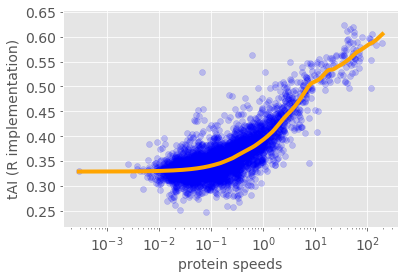

In [29]:
scatter_dicts(prot_speeds, tAI_dict_R, "protein speeds", "tAI (R implementation)", 14, 0.2, True, False)

4475


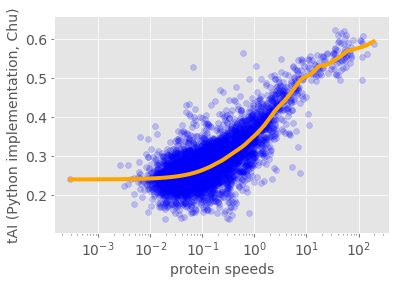

In [30]:
scatter_dicts(prot_speeds, tAI_dict_python_from_dict, "protein speeds", "tAI (Python implementation, Chu)", 14, 
              0.2, True, False)

4475


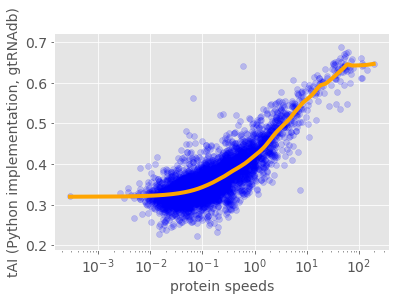

In [31]:
scatter_dicts(prot_speeds, tAI_dict_python_from_gtrnadb, "protein speeds", "tAI (Python implementation, gtRNAdb)", 
              14, 0.2, True, False)

Not a strong effect but the R implementation looks slightly better.

#### B. Protein speeds NOT including the initiation event (the correlation to tAI might be stronger here):

We are using the method at https://github.com/gittenberg/TRSL/blob/master/workbooks/analyses/03%20TRSL_check_observables.ipynb.

Get the tic_tocs:

In [32]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [33]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]])
                               for index in transcript_tic_toc}

/home/martin/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [35]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [36]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [37]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [38]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [39]:
orf_lengths = {prot: len(orfs[prot]) for prot in orfs}

In [40]:
pd.Series(orf_lengths.values()).describe()

count     6713.000000
mean      1352.414122
std       1139.682772
min         51.000000
25%        534.000000
50%       1077.000000
75%       1767.000000
max      14733.000000
dtype: float64

Still the same (check).

In [41]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [42]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

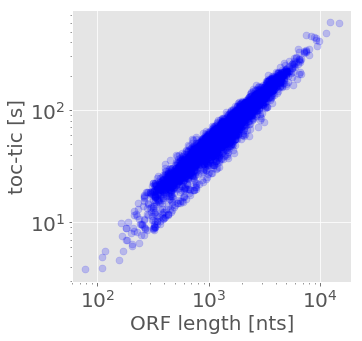

In [43]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.2, s=50, color='b')
ax.set_xlabel('ORF length [nts]', fontsize=20)
ax.set_ylabel('toc-tic [s]', fontsize=20)
plt.setp(plt.gca().get_xticklabels(), fontsize=20)
plt.setp(plt.gca().get_yticklabels(), fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')

In [44]:
df['Speed'] = df['ORF length [nts]'] / df['tic toc [s]']

In [45]:
df.dropna(how='any', inplace=True)

In [46]:
df.head()

,name,tic toc [s],ORF length [nts],Speed
0,YBR177C,59.901247,1356,22.637258
1,YIL140W,100.371746,2472,24.628445
2,YLR268W,33.104739,645,19.483616
3,YOR011W,214.940000,4185,19.470550
4,YPL043W,75.186086,2058,27.372086


In [47]:
df['Speed'].describe()

count    4475.000000
mean       21.675455
std         3.970934
min        12.443551
25%        19.094572
50%        21.032899
75%        23.287783
max        40.893672
Name: Speed, dtype: float64

In [48]:
tic_toc_speed_dict = dict(zip(df['name'] , df['Speed']))

4475


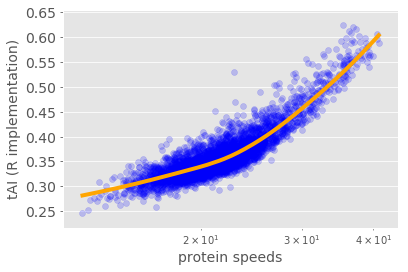

In [49]:
scatter_dicts(tic_toc_speed_dict, tAI_dict_R, "protein speeds", "tAI (R implementation)", 14, 0.2, 
                        True, False)

Inverted and linearly plotted:

4475


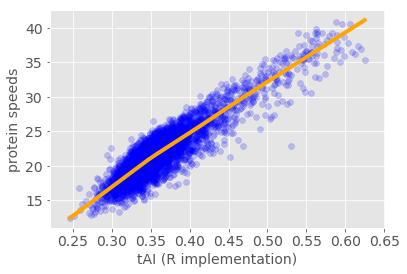

In [50]:
scatter_dicts(tAI_dict_R, tic_toc_speed_dict, "tAI (R implementation)",  "protein speeds", 14, 0.2, False, False)

4475


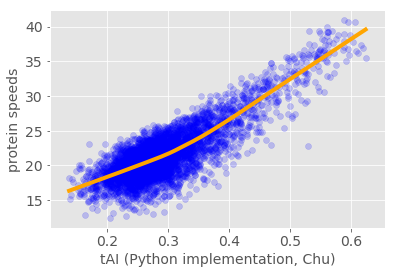

In [51]:
scatter_dicts(tAI_dict_python_from_dict, tic_toc_speed_dict, "tAI (Python implementation, Chu)", "protein speeds", 
              14, 0.2, False, False)

4475


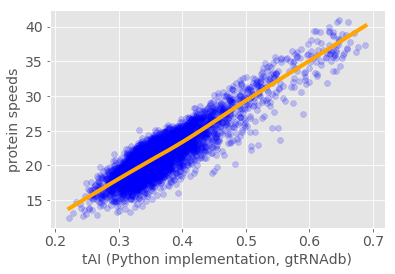

In [52]:
scatter_dicts(tAI_dict_python_from_gtrnadb, tic_toc_speed_dict, "tAI (Python implementation, gtRNAdb)", 
              "protein speeds", 14, 0.2, False, False)

Beautiful dependence of tic-toc speeds on tRNA adaptation (esp. the R implementation)!!!

#### C. Like A, but normalized by transcript count

In [53]:
transcriptome = pkl.load(open("../../parameters/transcriptome_shah.p", "rb"))

In [54]:
transcriptome_df = pd.DataFrame.from_dict(transcriptome, orient='index', dtype=None)
print len(transcriptome_df)

4839


In [55]:
prot_speeds_df = pd.DataFrame.from_dict(prot_speeds, orient='index', dtype=None)
print len(prot_speeds_df)

4475


In [56]:
total_df = pd.merge(transcriptome_df, prot_speeds_df, left_index=True, right_index=True, how='outer')
print len(total_df)

4839


In [57]:
total_df.columns = ['transcripts', 'prot_speeds']

In [58]:
total_df['prot_speed_per_transcript'] = total_df['prot_speeds'] / total_df['transcripts']
total_df.dropna(how='any', inplace=True)

In [59]:
total_df.head()

,transcripts,prot_speeds,prot_speed_per_transcript
YAL001C,2,0.039083,0.019541
YAL002W,1,0.010920,0.010920
YAL003W,322,53.933559,0.167496
YAL007C,14,0.879074,0.062791
YAL008W,3,0.257199,0.085733


In [60]:
prot_speed_per_transcript_dict = dict(zip(total_df.index, total_df['prot_speed_per_transcript']))

4475


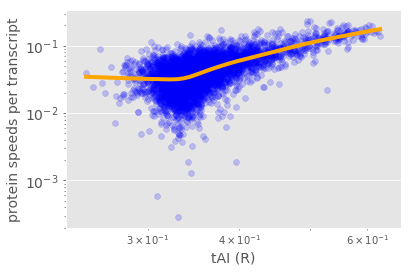

In [61]:
scatter_dicts(tAI_dict_R, prot_speed_per_transcript_dict, "tAI (R)",  "protein speeds per transcript", 14, 0.2, 
              True, True)

4475


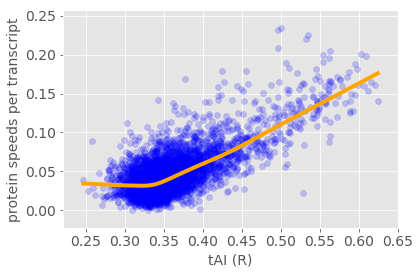

In [62]:
scatter_dicts(tAI_dict_R, prot_speed_per_transcript_dict, "tAI (R)",  "protein speeds per transcript", 14, 0.2, 
              False, False)

Seems to fit slightly worse that the unnormalized values. (Weird.)

4475


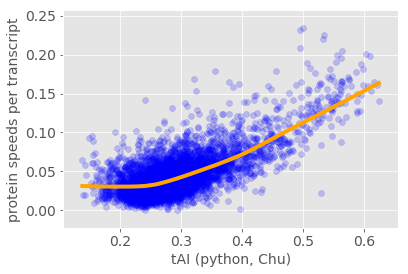

In [63]:
scatter_dicts(tAI_dict_python_from_dict, prot_speed_per_transcript_dict, "tAI (python, Chu)",  
              "protein speeds per transcript", 14, 0.2, False, False)

4475


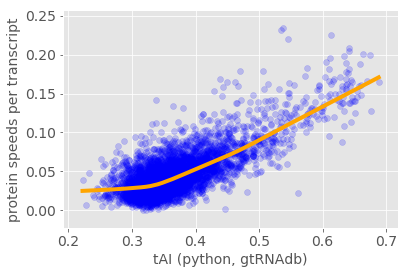

In [64]:
scatter_dicts(tAI_dict_python_from_gtrnadb, prot_speed_per_transcript_dict, "tAI (python, gtRNAdb)",  
              "protein speeds per transcript", 14, 0.2, False, False)

TODO: Double-check that previous values were really unnormalized!

In [65]:
pkl.dump(tAI_dict_R, open("../../parameters/tAI_codonR.p", "wb"))
pkl.dump(tAI_dict_python_from_gtrnadb, open("../../parameters/tAI_python_gtRNAdb.p", "wb"))
pkl.dump(tAI_dict_python_from_dict, open("../../parameters/tAI_python_chu.p", "wb"))

pkl.dump(prot_speeds, open("../../parameters/prot_speeds.p", "wb"))
pkl.dump(tic_toc_speed_dict, open("../../parameters/tic_toc_speed_dict.p", "wb"))

### Codon adaptation index (CAI)

Sharp and Li (Nucleic Acids Res. 1987 Feb 11;15(3):1281-95)

https://en.wikipedia.org/wiki/Codon_Adaptation_Index

CAI measures the deviation of a given protein coding gene sequence with respect to a reference set of genes.

CAI is simply defined as the geometric mean of the weight associated to each codon over the length of the gene sequence (measured in codons).

$$\text{CAI}=\exp \left( \frac{1}{L} \sum_{l=1}^L{\log \left(w_i(l)\right)}\right)$$

where $$w_i=\frac{f_i}{\max(f_j)} \qquad i,j \in [\text{synonymous codons for amino acid}]$$

In [66]:
import os.path
from Bio.SeqUtils.CodonUsage import CodonAdaptationIndex

In [67]:
CAI = CodonAdaptationIndex()

In [68]:
datadir = "../../data"
sequencefile = "orf_coding.fasta"
#sequencefile = "orf_coding_all.fasta" # not working (stops at a pseudogene fragment)
sequencefile = os.path.join(datadir, sequencefile)

In [69]:
CAI.generate_index(sequencefile)

In [70]:
handle = open(sequencefile, "rU")
record_dict = SeqIO.to_dict(SeqIO.parse(handle, "fasta"))
handle.close()
orf_genomic_dict = {key:str(record_dict[key].seq).lower().replace('t', 'u') for key in record_dict}

Generate a dictionary of all CAIs:

In [71]:
cai_dict = {}
for gene in orf_genomic_dict:
    orf_genomic_dict[gene] = orf_genomic_dict[gene].replace('u', 't')
    cai_dict[gene] = CAI.cai_for_gene(orf_genomic_dict[gene])

In [72]:
pkl.dump(cai_dict, open("../../parameters/cai_dict.p", "wb"))
pkl.dump(tAI_dict_R, open("../../parameters/tAI_dict_R.p", "wb"))

Scatter CAI vs tAI:

5917


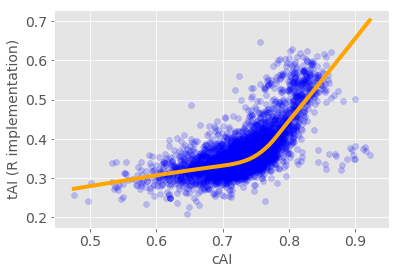

In [73]:
scatter_dicts(cai_dict, tAI_dict_R, "cAI", "tAI (R implementation)", 14, 0.2, False, False)

Scatter CAI vs tic_toc_speed_dict:

4475


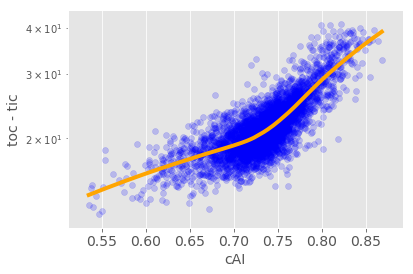

In [74]:
scatter_dicts(cai_dict, tic_toc_speed_dict, "cAI", "toc - tic", 14, 0.2, False, True)

Not logarithmic:

4475


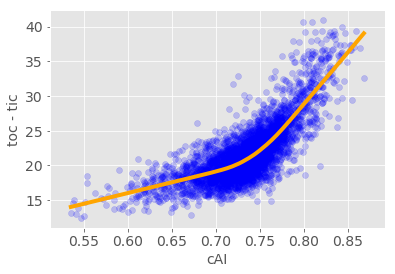

In [75]:
scatter_dicts(cai_dict, tic_toc_speed_dict, "cAI", "toc - tic", 14, 0.2, False, False)

### tAI vs length

Next we check tAI vs length (to test the ramp - beginning of gene should be slower, hence have lower translation efficiency, hence lower (?) tAI).

We need to take only ORFs longer than x and then take the first 30, 60, 90, 120 nts and calculate their tAI.

TODO! (perhaps in R)